In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.iclr.helper import find_best_validation_epoch_from_train_stats
from tf_lab.point_clouds.convenience import get_latent_codes

In [3]:
from tf_lab.voxels.soup import load_voxel_grids_from_filenames, plot_isosurface, \
                               read_tartachenko_car_bin_vox, read_bin_vox_file,\
                               load_data_for_rebuttal, reconstruct_voxels,\
                               uniform_sampling_of_voxels
                            
        
from tf_lab.voxels.voxel_ae import Voxel_AE
from sklearn import mixture
from general_tools.simpletons import iterate_in_chunks

In [4]:
from tf_lab.iclr.evaluator import Evaluator

In [5]:
from geo_tool.solids.plotting import plot_mesh_via_matplotlib as plot_mesh

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
# experiment_tag = 'sn_vox_data'
experiment_tag = 'phuoc_data'
load_phuoc = True
vox_resolution = 64

load_tartachenko = False
b_neck = 64
occupied_thres = 0.5
n_pc_points = 2048
class_name = 'chair'
n_clusters = 32
cov_t = 'full'

ae_experiment_name = '_'.join(['ae', class_name, experiment_tag, str(vox_resolution), 
                               'voxels', str(b_neck), 'bneck'])

In [8]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
top_syn_dir = osp.join(top_data_dir, 'OUT/iclr/synthetic_samples/voxel_based/gmm')

In [9]:
voxel_data = load_data_for_rebuttal(load_tartachenko=False, load_phuoc=True, 
                                    class_name=class_name, resolution=vox_resolution)

['voxels', 'labels']
['voxels', 'labels']
['voxels', 'labels']


In [10]:
train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/', ae_experiment_name)
ae_conf = Conf.load(osp.join(train_dir, 'configuration'))
reset_tf_graph()
ae = Voxel_AE(ae_conf.experiment_name, ae_conf)
val_error, best_epoch = find_best_validation_epoch_from_train_stats(osp.join(train_dir, 'train_stats.txt'))
ae.restore_model(ae_conf.train_dir, best_epoch, verbose=True)
print val_error
latent_codes = get_latent_codes(ae, voxel_data['train'].voxels)

INFO:tensorflow:Restoring parameters from /orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/ae_chair_phuoc_data_64_voxels_64_bneck/models.ckpt-50
Model restored in epoch 50.
0.059758521


In [11]:
gmm = mixture.GaussianMixture(n_clusters, cov_t)
gmm.fit(np.squeeze(latent_codes))
n_syn_samples = len(latent_codes)
gmm_syn_data = gmm.sample(n_syn_samples)[0]
gmm_syn_data = gmm_syn_data.reshape(n_syn_samples, 1, 1, 1, b_neck)

In [12]:
syn_decoded = np.zeros(shape=(n_syn_samples, vox_resolution, vox_resolution, vox_resolution))
for idx in iterate_in_chunks(range(n_syn_samples), 100):
    dec = ae.decode(gmm_syn_data[idx])
    dec = np.squeeze(dec)
    dec = ae.sess.run(tf.nn.sigmoid(dec))
    syn_decoded[idx] = dec

In [17]:
from skimage import measure
from geo_tool import Mesh

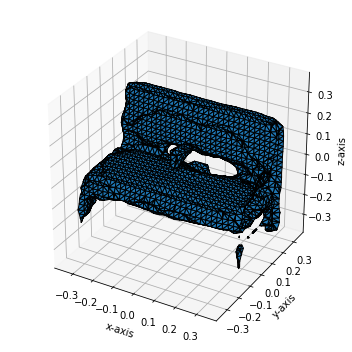

In [32]:
k = 1
plot_isosurface(syn_decoded[k], occupied_thres)

verts, faces, _, _ = measure.marching_cubes(syn_decoded[k], occupied_thres)
m = Mesh(vertices=verts, triangles=faces)
plot_mesh(m)
m = m.largest_connected_component()
plot_mesh(m)

In [20]:
syn_out_dir = osp.join(top_syn_dir, ae_experiment_name)
create_dir(syn_out_dir)
syn_pcs = uniform_sampling_of_voxels(syn_decoded, n_pc_points, occupied_thres, only_lcc=True)

/orions4-zfs/projects/optas/Git_Repos/geo_tool/solids/mesh.py:202: UserWarning: The mesh has triangles with non positive area.
  warnings.warn('The mesh has triangles with non positive area.')


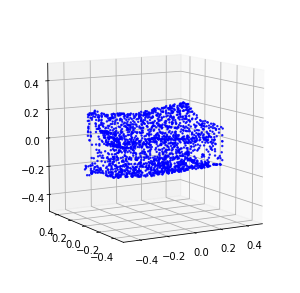

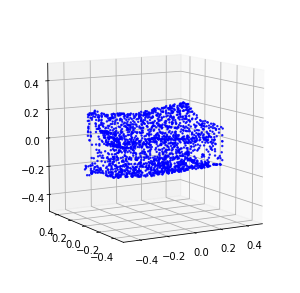

In [22]:
Point_Cloud(syn_pcs[8]).plot()

In [23]:
np.savez(osp.join(syn_out_dir, 'samples_with_lcc'),  syn_pcs)